## Segment a sparse 3D image with a single material component  

The goal of this notebook is to develop a 3D segmentation algorithm that improves segmentation where features are detected.

**Data:** AM parts from Xuan Zhang. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
import time
import seaborn as sns
import pandas as pd

import cupy as cp
from tomo_encoders import Patches
from tomo_encoders.misc import viewer
from tomo_encoders import DataFile
from tomo_encoders.reconstruction.recon import recon_binning, recon_patches_3d, rec_patch, rec_pts, rec_pts_xy, rec_mask, make_mask, extract_from_mask
# from tomo_encoders.misc.voxel_processing import cylindrical_mask, normalize_volume_gpu

In [2]:
r_fac = 0.2
nc = 32
n = 2176
ntheta = 1500
n_sel = int(nc*n*n*r_fac/(32**3))

In [3]:
# arguments to recon_chunk2: data, theta, center, p3d
data_cpu = np.random.normal(0,1,(ntheta, nc, n)).astype(np.float32)
theta_cpu = np.linspace(0, np.pi, ntheta, dtype = np.float32)
center_cpu = n/2.0
p_sel = Patches((nc,n,n), initialize_by = 'regular-grid', patch_size = (32,32,32), n_points = n_sel)
print(f'r = N(P)/N(V): {len(p_sel)*32**3/(nc*n*n):.2f}')

r = N(P)/N(V): 0.20


In [4]:
start_gpu = cp.cuda.Event(); end_gpu = cp.cuda.Event(); start_gpu.record()
stream = cp.cuda.Stream()
with stream:
    data = cp.empty((ntheta, nc, n), dtype = cp.float32)
    theta = cp.empty(ntheta, dtype = cp.float32)
    center = cp.float32(0.0)
    obj_mask = cp.empty((nc, n, n), dtype = cp.float32)
    
end_gpu.record(); end_gpu.synchronize(); t_meas = cp.cuda.get_elapsed_time(start_gpu,end_gpu)
print(f"overhead for allocating memory on gpu: {t_meas:.2f} ms")

overhead for allocating memory on gpu: 1.32 ms


In [5]:
start_gpu = cp.cuda.Event(); end_gpu = cp.cuda.Event(); start_gpu.record()
stream = cp.cuda.Stream()
with stream:
    data.set(data_cpu)
    theta.set(theta_cpu)
    center = cp.float32(center_cpu)
end_gpu.record(); end_gpu.synchronize(); t_meas = cp.cuda.get_elapsed_time(start_gpu,end_gpu)
print(f"overhead for copying data to gpu: {t_meas:.2f} ms")

overhead for copying data to gpu: 48.07 ms


## rec_mask  
output to obj_mask  

In [6]:
t_mask = make_mask(obj_mask, p_sel.points)

overhead for making mask from patch coordinates: 33.44 ms


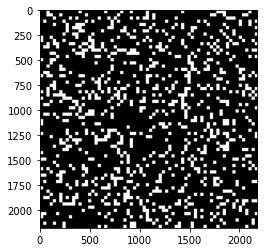

In [7]:
mask = obj_mask.copy()
plt.imshow(mask[nc//2].get(), cmap = 'gray')

In [8]:
t_rec = rec_mask(obj_mask, data, theta, center)

TIME rec_mask: 304.26 ms


In [9]:
sub_vols, t_gpu2cpu = extract_from_mask(obj_mask, p_sel.points)

overhead for extracting sub_vols to cpu: 136.69 ms


# rec_full  

In [ ]:
times = []
for i in range(5):
    obj_patch, t_ = rec_patch(data, theta, center, 0, n, 0, n, 0, nc, TIMEIT=True)
    print(f"time {t_:.2f} ms")
    times.append(t_)
print(f"time = {np.median(times):.2f} ms")    

time 1355.52 ms
time 1309.27 ms
time 1314.35 ms
time 1316.12 ms


In [ ]:
start_gpu = cp.cuda.Event(); end_gpu = cp.cuda.Event(); start_gpu.record()
stream = cp.cuda.Stream()
_ = obj_patch.get()
end_gpu.record(); end_gpu.synchronize(); t_meas = cp.cuda.get_elapsed_time(start_gpu,end_gpu)
print(f"overhead for copying full object to cpu: {t_meas:.2f} ms")    

In [ ]:
vox_coords = np.where(mask==1)
idp = nc//2
is_reconcile = ~np.any(obj_patch[vox_coords]-obj_mask[vox_coords])
print(f'Does the reconstruction of points reconcile with the full volume? {is_reconcile}')
fig, ax = plt.subplots(1,3, figsize = (18,6))
ax[0].imshow(mask[idp].get(), cmap = 'gray')
ax[1].imshow(obj_mask.get()[idp], cmap = 'gray')
ax[2].imshow(obj_patch.get()[idp], cmap = 'gray')